#  Complementary material.

# Objective: 

To determine computationally which distribution the TPA follows for two ways of calculating it for the f-scan technique.

- 1) Inverse function method.
- 2) Regression method.

In [6]:
# LIBRARIES
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

%matplotlib inline 
font = {'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta


# Base functions used throughout the code

In [8]:
def fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+(z/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    '''
    This function computes TPA using method 1.
    '''

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample 
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+(z/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Function to add Gaussian noise given a standard deviation

    Parameters
    ----------
    signal: Array
      Array with the signal to which the noise is to be added.
    dev: float
      Standard deviation
    '''
    señal_ruido=[np.random.normal(señal[i], abs(señal[i]*desv)) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Function to verify central limit theorem

    Parameters
    -----------
    s: Array
     Array of data to which the theorem is to be applied.
    k: float
     Number of data to average

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):

    '''
    Function to verify if a given array follows a Gaussian distribution

    Parameters
    -----------
    s: Array
     Array of data to which the theorem is to be applied.

'''
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


# Data assumed to be real:

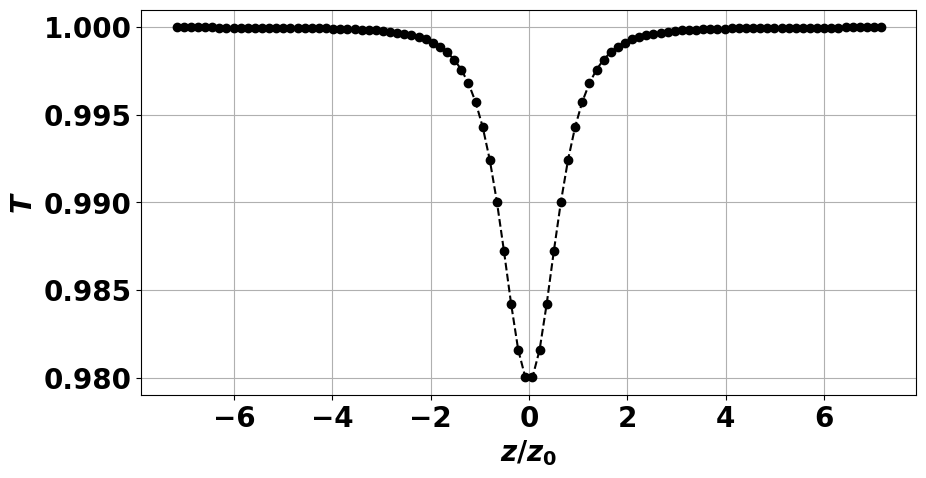

In [9]:
fig=plt.figure(figsize=(10,5))

beta = 3.4e-11 # TPA seed in (m/W )
L= 1e-3 # thickness in (m).
Pavg = 200e-3# Average power in (W)
Tp =  200e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
focal =15e-2 # Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 2.6e-1 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ
w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
z0 = np.pi*w0**2/wl # Rayleigh range
z=np.linspace(-1/2*focal,1/2*focal,100)#focal distance [m]
T=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
plt.plot(z/z0,T,'--ko',label='simulated signal')
#plt.title('$Z-scan$')
plt.xlabel('$z/z_0$',fontsize=20)
plt.ylabel('$T$',fontsize=20)
plt.grid()
#plt.plot(corriente,Td,'--ro',label='derivada')

# 1) Method 1.
In this method, we have the following equation that gives the physical parameter of interest:

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{z}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(z,β;\{L,f, P_{av}, T_{p}, w_{l}, D, C_f, \alpha, R\})\right] \hspace{2 mm} (1)$$



In [10]:
def dist_betas(N,desv,k,par): 
    '''
    This function computed TPA using method 1 and gives the distribution

    Parameters
    ----------
    N: float
        Number of values ​​with which the histogram will be formed
    desv: float
        percentage of relative error.
    k: float
        focal distance index.
    par: array
        array of 0 or 1 depending on which parameter you want to investigate.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal]

        The function returns the distribution of beta
    '''
  

    TPA=[]
    TT=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
    trans=TT[k]   
    er=desv/(100)
    er_L=er*par[0]
    er_P=er*par[1]
    er_T=er*par[2]
    er_wl=er*par[3]
    er_D=er*par[4]
    er_focal=er*par[5]
    er_Cf=er*par[6]
    er_a=er*par[7]
    er_R=er*par[8]
    er_freq=er*par[9]
    er_trans=er*par[10]
    er_z=er*par[11]


    for ii in range(N):


        L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
        Tp_f = np.random.normal(Tp,Tp*er_T,1) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
        z_f = np.random.normal(z[k],abs(z[k])*er_z,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
        alfa_f = (np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,R*er_R,1) # Reflectance
        freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,abs(trans)*er_trans,1)
        focal_f=np.random.normal(focal,focal*er_focal,1) 
        
        TPA.append(BETA(trans_f,z_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
    return TPA

Our purpose here is to verify in general for which error values the distribution of betas follows a Gaussian distribution. In general, there are different values of current that can be selected to perform the beta calculation and thus obtain a distribution. Therefore, all values within the already defined range (0,300) mA should be checked.

# Variation of all parameters method 1.

In this case we introduce error in all parameters and investigate the distribution associated.

In [11]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,150) #Porcentaje de error
params=np.ones(12)
final=np.zeros((len(er_r),len(z)))

for k in range(len(z)):

    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas(2000,j,k,params))
        criterio=confirm_gauss(beta_hist)
        final[c,k]=criterio
        

([<matplotlib.axis.YTick at 0x24ac8714b10>,
 [Text(0, 0, '0.0'),
  Text(0, 30, '2.02'),
  Text(0, 60, '4.03'),
  Text(0, 90, '6.04'),
  Text(0, 120, '8.05')])

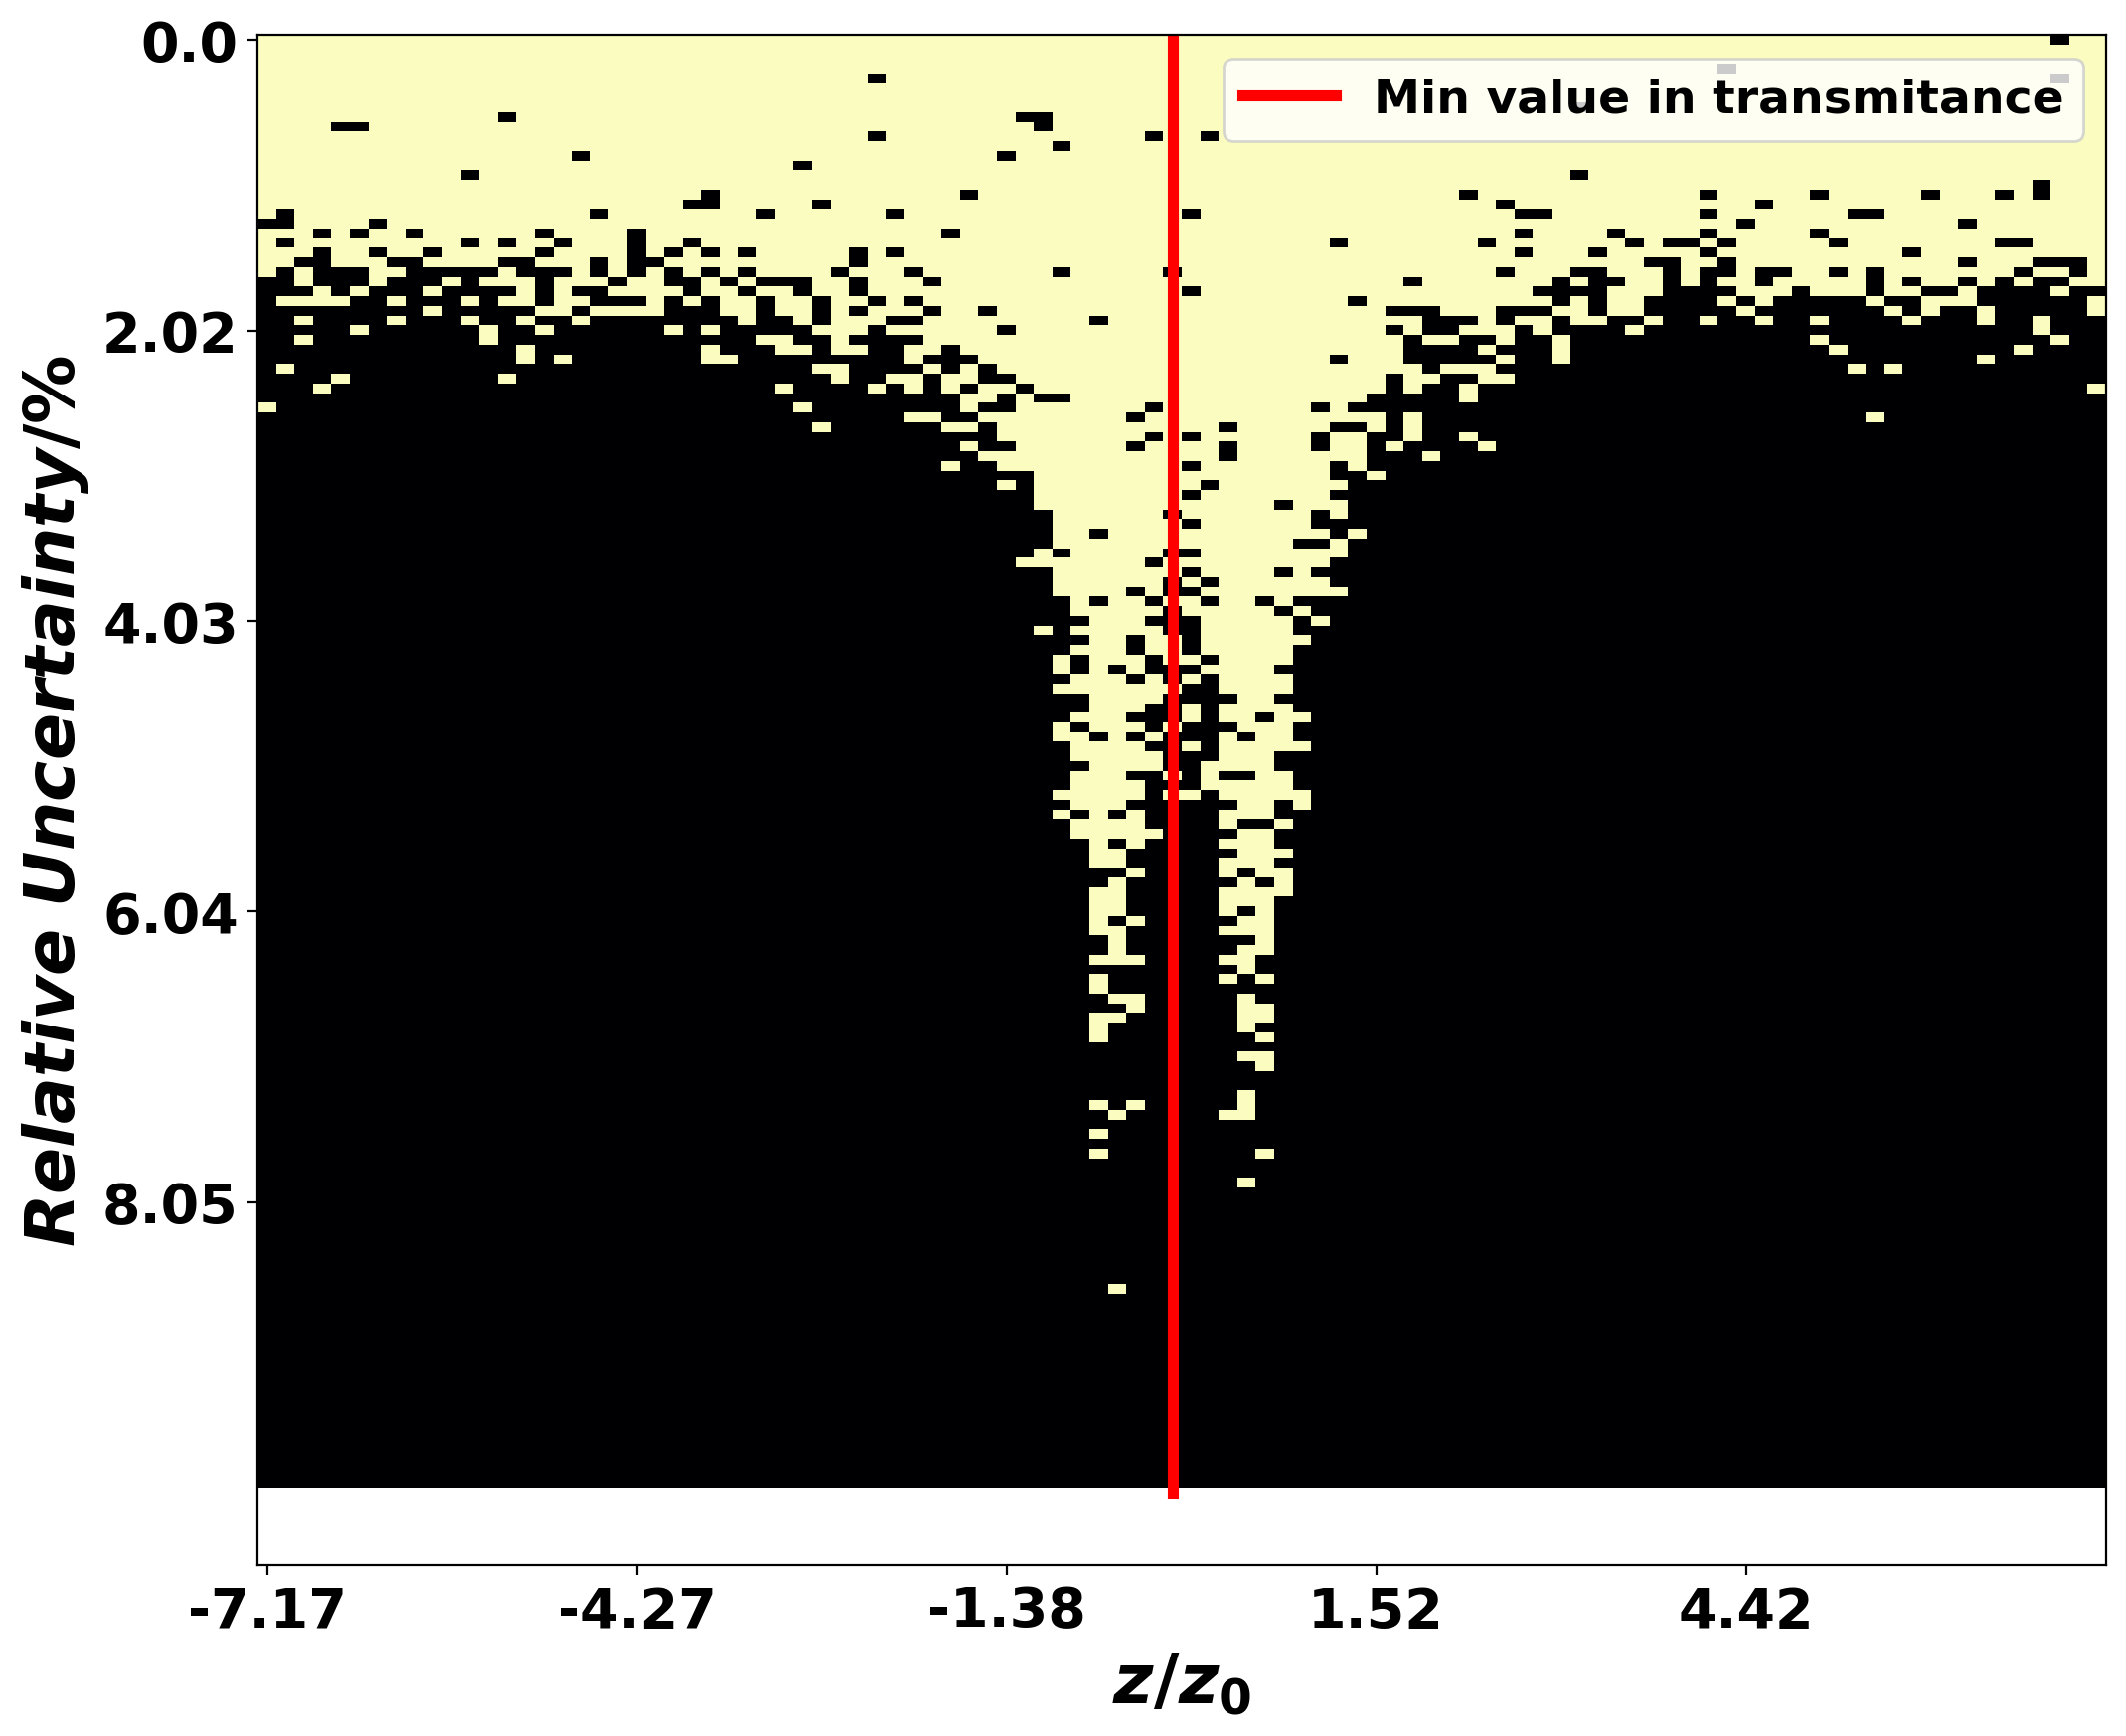

In [12]:
f=plt.figure(figsize=(12,10),dpi=200)

er_r=np.linspace(0.005,10,150) #Porcentaje de error

plt.imshow(final, cmap='magma',interpolation='nearest', aspect='auto')
plt.plot([index,index],[len(er_r),0],'r',lw=4,label='Min value in transmitance')
plt.ylabel('$Relative$ $Uncertainty/\%$',fontsize=25)
plt.xlabel('$z/z_0$',fontsize=25)
plt.legend(fontsize=17)
#plt.colorbar()

nx = z.shape[0]
no_labels = 6 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round((z/z0)[::step_x],2) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

ny = er_r.shape[0]
no_labels = 6 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],2) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


The above plot shows that the distribution of betas will generally not be Gaussian. However, for small errors, in the vicinity of the focal length value corresponding to the minimum transmittance, the distribution of betas can be said to be Gaussian.

# Variation in a single parameter method 1.

In this case we introduce error in each parameter and investigate the distribution associated.

In [8]:
results=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))

for i in range(0,12):


    final=np.zeros((len(er_r),len(z)))

    for k in range(len(z)):

        for c,j in enumerate(er_r):

            beta_hist=np.array(dist_betas(500,j,k,params[i,:]))
            criterio=confirm_gauss(beta_hist)
            final[c,k]=criterio
    
    results.append(final)


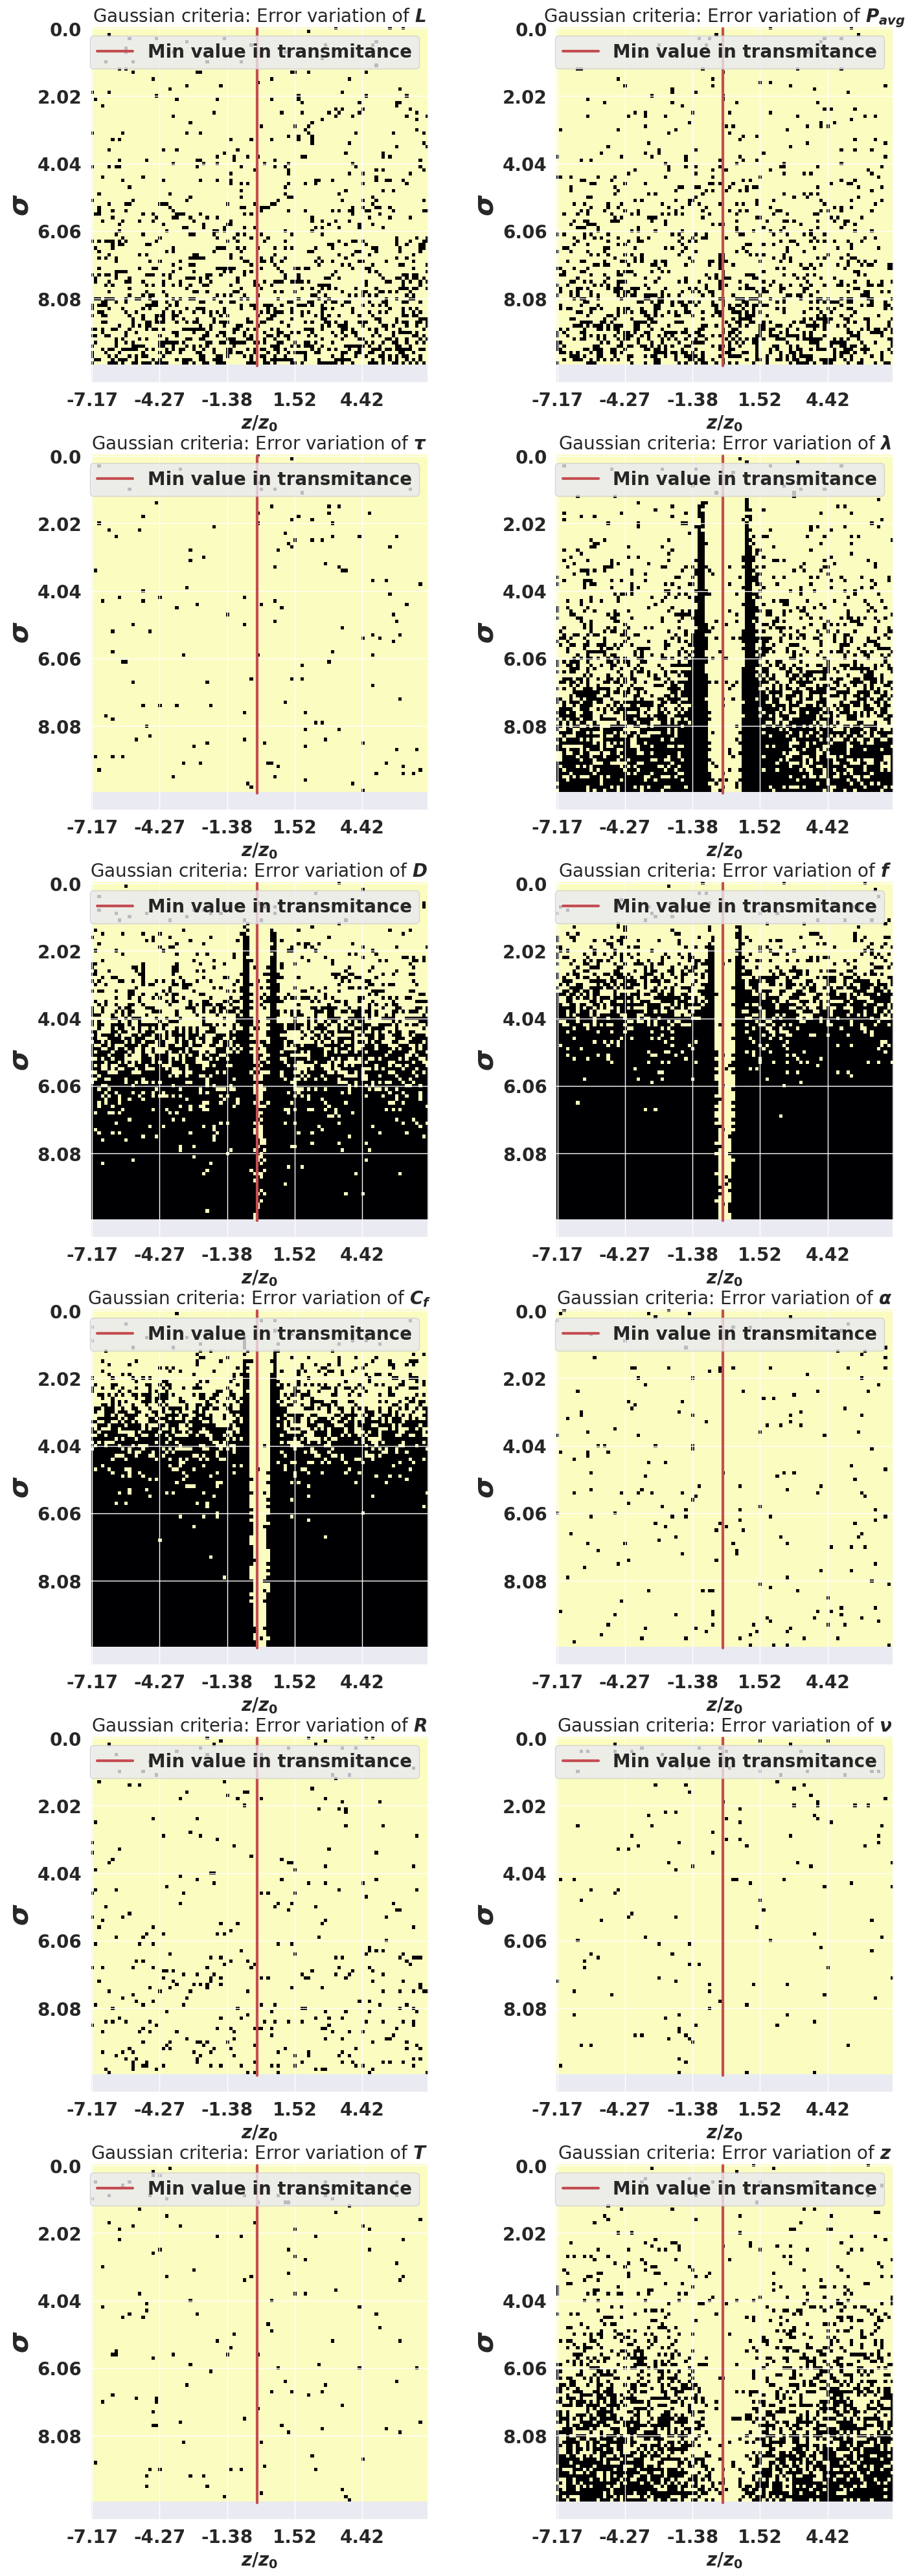

In [9]:
f=plt.figure(figsize=(17,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for c,i in enumerate(results):

    plt.subplot(6,2,iters)

    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    plt.imshow(i, cmap='magma')
    plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
    plt.ylabel('$\sigma$',fontsize=30)
    plt.xlabel('$z/z_0$',fontsize=20)
    plt.title(r'Gaussian criteria: Error variation of '+titles[c],fontsize=20)
    plt.legend(fontsize=20)
 

    nx = (z/z0).shape[0]
    no_labels = 6 # how many labels to see on axis x
    step_x = int(nx / (no_labels - 1)) # step between consecutive labels
    x_positions = np.arange(0,nx,step_x) # pixel count at label position
    x_labels = np.round( (z/z0)[::step_x],2) # labels you want to see
    plt.xticks(x_positions, np.sort(x_labels),fontsize=20)

    ny = er_r.shape[0]
    no_labels = 6 # how many labels to see on axis x
    step_y = int(ny / (no_labels - 1)) # step between consecutive labels
    y_positions = np.arange(0,ny,step_y) # pixel count at label position
    y_labels = np.round(er_r[::step_y],2) # labels you want to see
    plt.yticks(y_positions, np.sort(y_labels),fontsize=20)

    iters+=1

    

# Method 2: Linear regression.

The method of obtaining the physical parameter is done by regression to the equation:

$$T(z,β;\{L,f, P_{av}, T_{p}, w_{l}, D, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{z}{z_0(f)}\right)^{2}} \hspace{2 mm} (2)$$

From the theory it follows that $g(x,\beta;\{v_i\})=\beta r(x;\{v_i\})+h(x;\{v_i\})$, in our case $$h(x;\{v_i\})=1$$ 
$$ r(x;\{v_i\})=-\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{z}{z_0(f)}\right)^{2}}$$
Therefore,

$$\beta=\frac{\sum_{l=1}^{n}r(x_l;\{ v_{i}\}) \left[y_l-h(x_l;\{ v_{i}\})\right]}{\sum_{l=1}^{n}r^{2}(x_l;\{ v_{i}\})}. \hspace{2 mm} (3) $$

In [8]:
# Función ajustar
def BETA2(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):
    '''
    This function computes TPA using method 2 formula

    '''
    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((z)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv,params): 
  
  '''
    This function computes TPA using method 1 and gives the distribution

    Parameters
    ----------
    N: float
        Number of values ​​with which the histogram will be formed
    desv: float
        percentage of relative error.
    params: array
        array of 0 or 1 depending on which parameter you want to investigate.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal]

        The function returns the distribution of beta
    '''
  
  # Contedra valores de TPA
  TPA=[]
  er=desv/(100)
  
  for ii in range(N):
      
      TT=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
      er_L=er*params[0]
      er_P=er*params[1]
      er_T=er*params[2]
      er_wl=er*params[3]
      er_D=er*params[4]
      er_focal=er*params[5]
      er_Cf=er*params[6]
      er_a=er*params[7]
      er_R=er*params[8]
      er_freq=er*params[9]
      er_trans=er*params[10]
      er_z=er*params[11]
      trans_f=ruido(TT,er_trans) #Minimo de la señal simulada. 
      z_f=ruido(z,abs(er_z))  #Distancia focal correspondiente al minimo.   
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      focal_f = np.random.normal(focal,focal*er_focal,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance   
      TPA.append(BETA2(trans_f,z_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,Cf_f,alfa_f,R_f,freq_f)*1e11)
          
  return TPA


# Variation in all parameters  method 2.

In [9]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
decis=[]
params=np.ones(12)

for j in er_r:
    
    beta_hist=np.array(dist_betas2(500,j,params))
    criterio=confirm_gauss(beta_hist)
    decis.append(criterio)

([<matplotlib.axis.XTick at 0x7f3f2cea1f90>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10')])

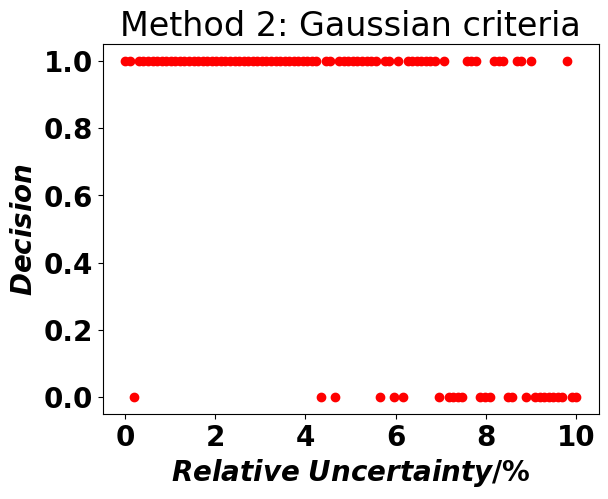

In [10]:
plt.plot(er_r,decis,'ro')
plt.xlabel('$Relative$ $Uncertainty/\%$')
plt.ylabel('$Decision$')
plt.title('Method 2: Gaussian criteria')
plt.xticks([0,2,4,6,8,10],fontsize=20)

# Variation in a single parameter method 2:

In [11]:
results2=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
params=np.diag(np.ones(12))

for i in range(0,12):
    
    final=[]

    
    for c,j in enumerate(er_r):

        beta_hist=np.array(dist_betas2(500,j,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    
    results2.append(final)


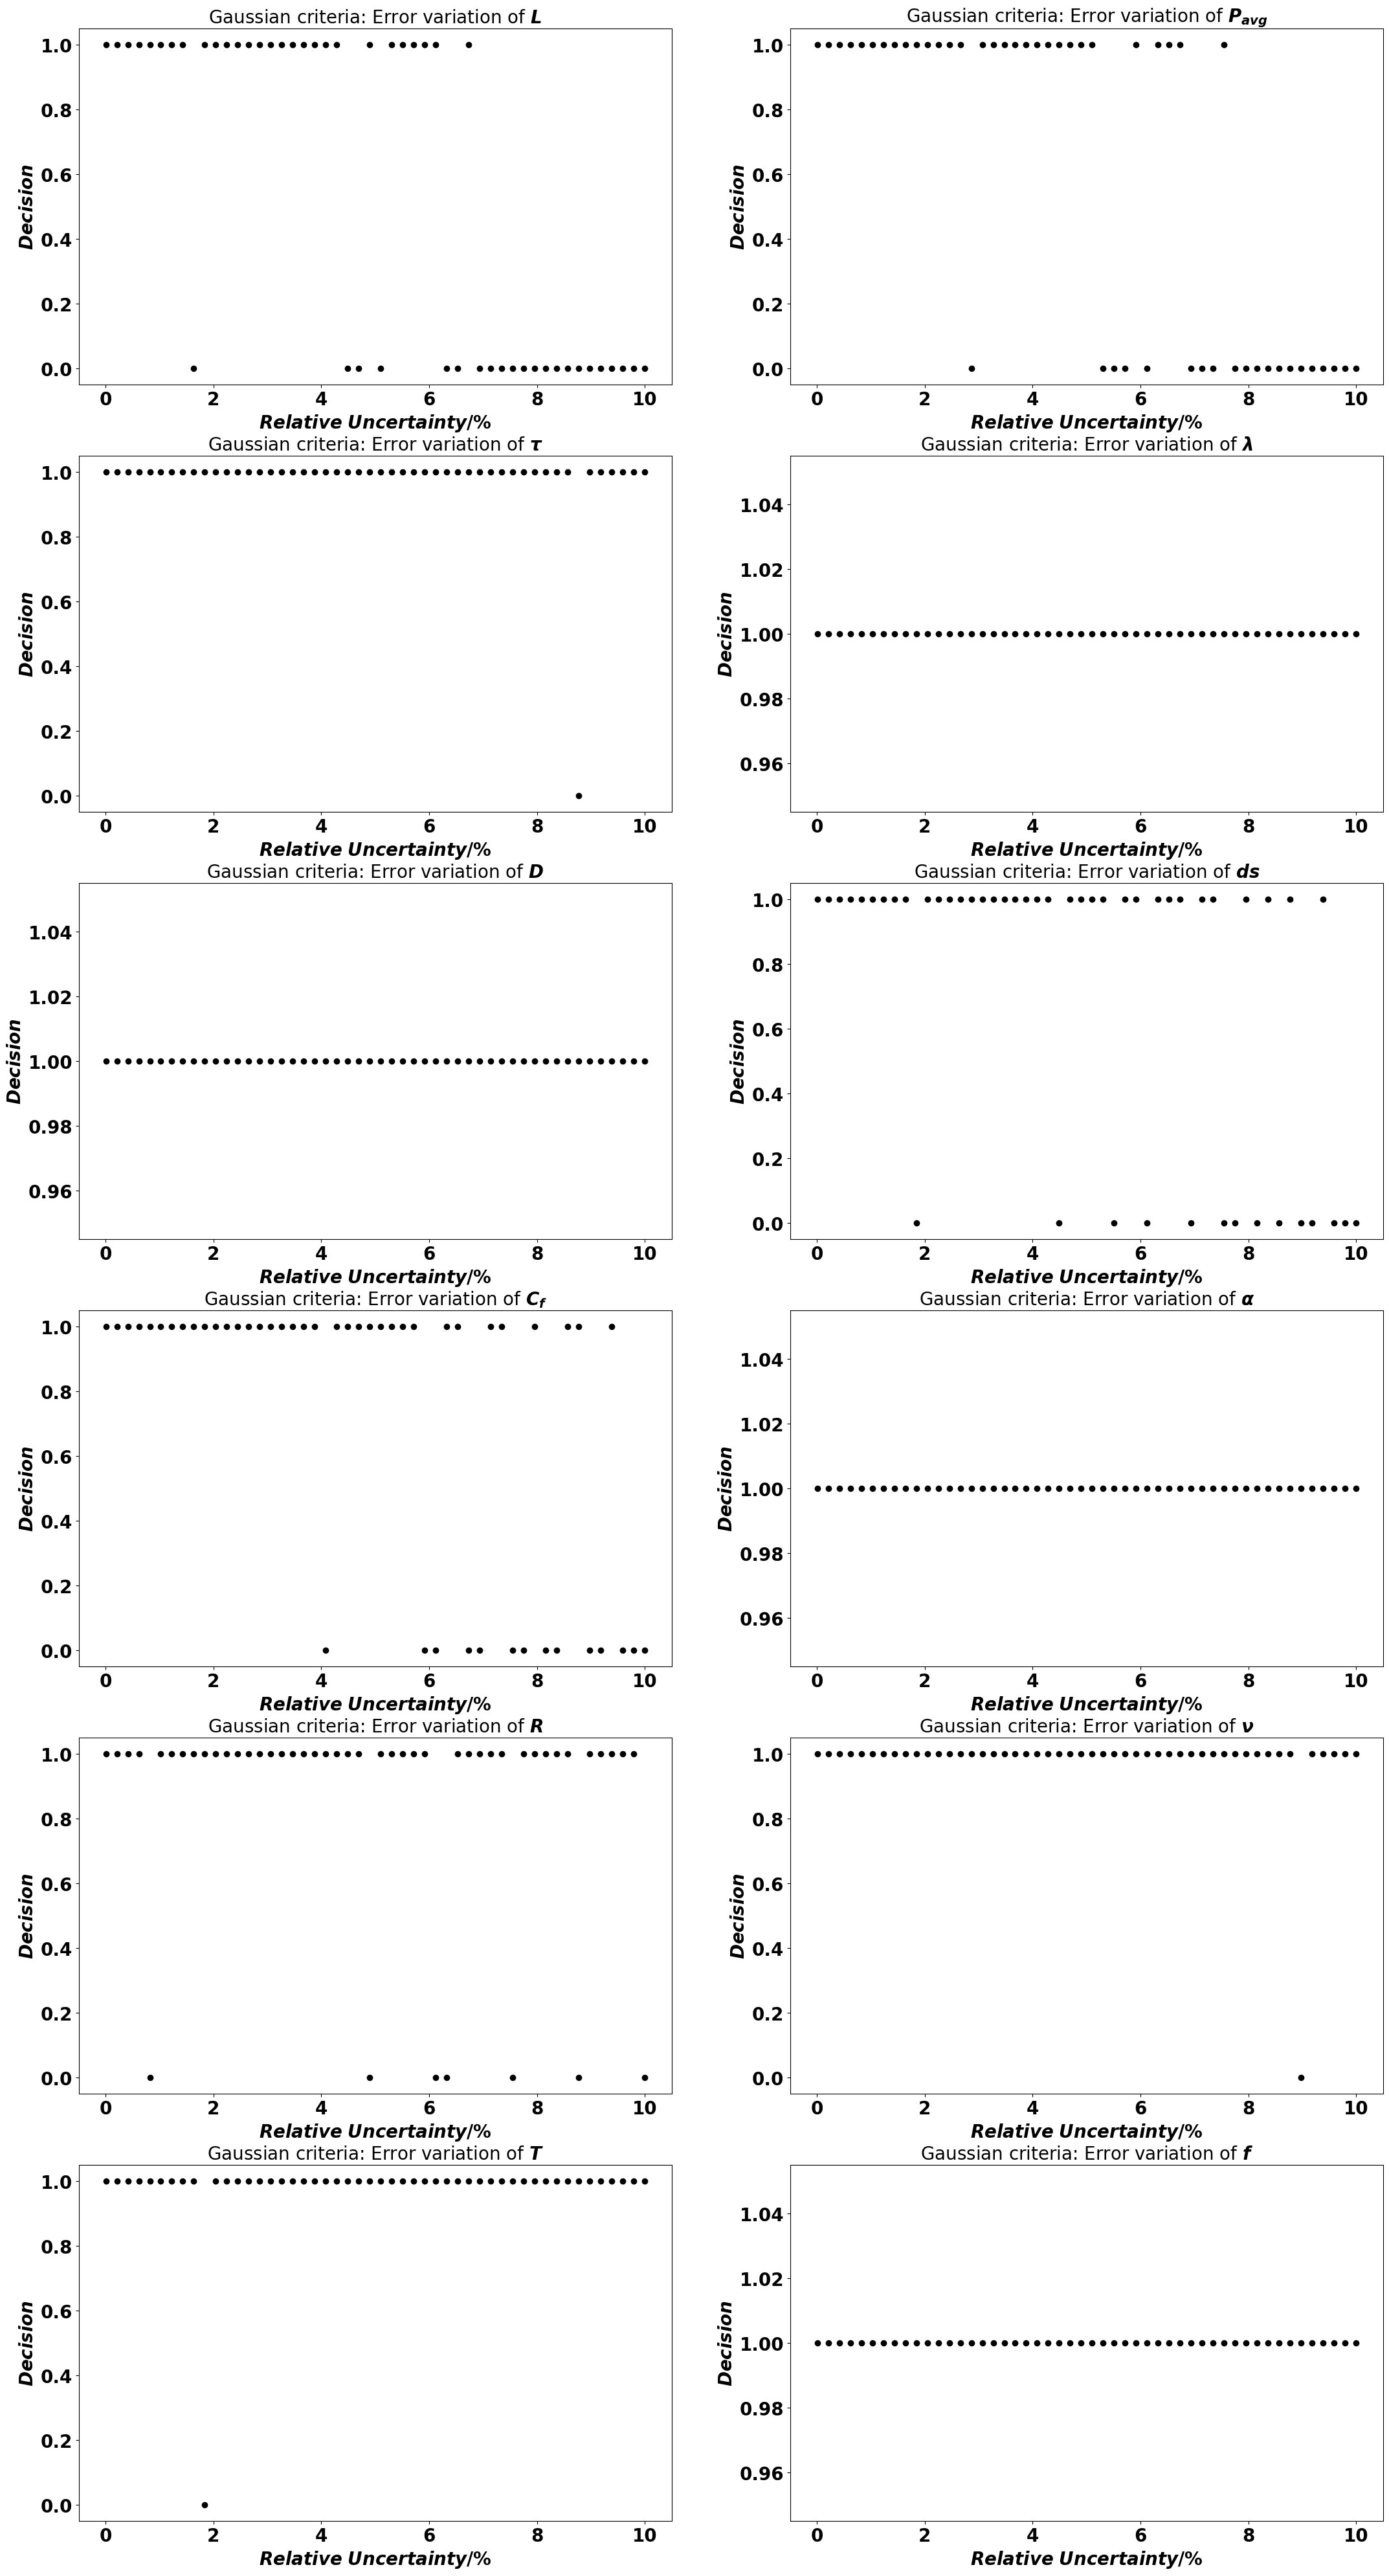

In [12]:
f=plt.figure(figsize=(26,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for c,i in enumerate(results2):

    plt.subplot(6,2,iters)
    plt.plot(er_r,i,'ko')
    plt.xlabel('$Relative$ $Uncertainty/\%$',fontsize=20)
    plt.ylabel('$Decision$',fontsize=20)
    plt.xticks([0,2,4,6,8,10],fontsize=20)
    plt.title(r'Gaussian criteria: Error variation of '+titles[c],fontsize=20)
    iters+=1
 

    